# Trying to simulate a particle moving with constant velocity
I will append each step to some dataset and figure out a way to display it with matplotlib.\
Note that I ended up using list comprehension which I don't think would work well if I wanted another particle to interact.

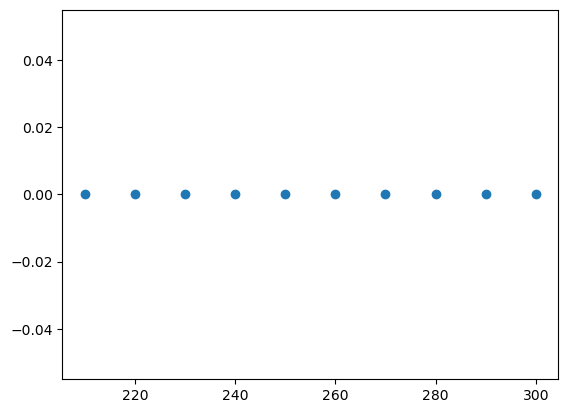

In [1]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt

## Initial conditions
position = np.array([300, 0])
velocity = np.array([-10, 0])

## Simulating parameters
starttime = 0
dt = 1
totaltime = 10

simulation = np.array([position + velocity*d for d in range(starttime, totaltime, dt)])

plt.scatter(np.transpose(simulation)[0], np.transpose(simulation)[1])
plt.show()


# Adding accelleration
I was still able to use list comprehension

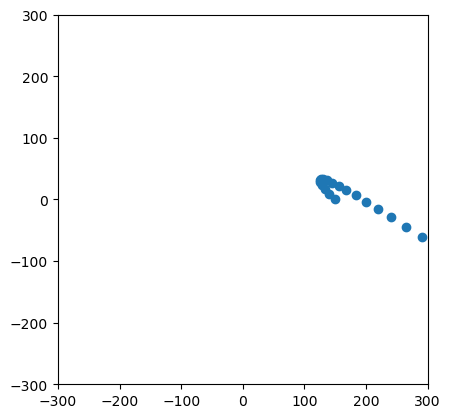

In [2]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt

## Initial conditions
position     = np.array([150, 0])
velocity     = np.array([-10, 10])
acceleration = np.array([2, -1.5])

## Simulating parameters
starttime = 0
dt = 1
endtime = 20
totaltime = endtime - starttime

simulation = np.array([position + velocity*d + 0.5*acceleration*d**2 for d in np.linspace(starttime, totaltime, int(totaltime//dt))])


fig, ax = plt.subplots()
ax.scatter(np.transpose(simulation)[0], np.transpose(simulation)[1])
ax.set_aspect('equal')
ax.set_ylim((-300, 300))
ax.set_xlim((-300, 300))
plt.show()

## Making another particle interact
I don't know if list comprehension could be used here (maybe with a yeild keyword in some method for particle)\
But this code is what made sense to me.
TODO: step each particle forward at the same time

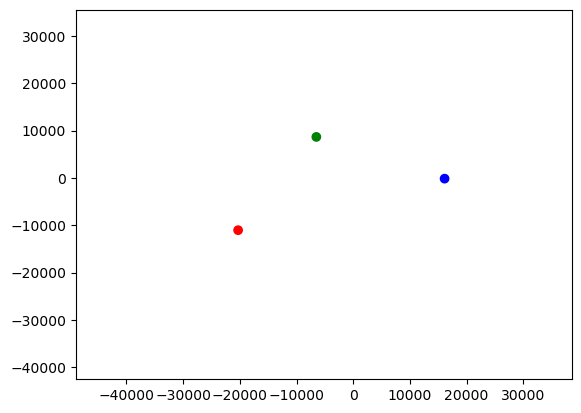

In [ ]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
import matplotlib.animation as anim

class particle(object):
    def __init__(self, xpos, ypos, xvel, yvel, xacc, yacc, mass):
        self.xpos = xpos
        self.ypos = ypos
        self.xvel = xvel
        self.yvel = yvel
        self.xacc = xacc
        self.yacc = yacc
        self.mass = mass

    def step(self, dt=1, gravconst=6.67e-11, others=[]):
        others = np.array(others).astype(particle)
        xgravforce = 0
        ygravforce = 0
        for part in others:
            distancevec = [self.xpos - part.xpos, self.ypos - part.ypos]
            distancemag = np.sqrt(distancevec[0]**2+distancevec[1]**2)
            xgravforce += -distancevec[0]*gravconst*self.mass*part.mass/distancemag**3
            ygravforce += -distancevec[1]*gravconst*self.mass*part.mass/distancemag**3
        self.xacc = xgravforce/self.mass
        self.yacc = ygravforce/self.mass
        self.xvel += 0.5*self.xacc*dt**2
        self.yvel += 0.5*self.yacc*dt**2
        self.xpos += 0.5*self.xvel*dt**2
        self.ypos += 0.5*self.yvel*dt**2

## With these initial conditions the system should have radial symmetry forever
one = particle(1e4, 0, 0, 18e2, 0, 0, 5e20)
two = particle(1e4*np.cos(2*np.pi/3), 1e4*np.sin(2*np.pi/3), -18e2*np.sin(2*np.pi/3), 18e2*np.cos(2*np.pi/3), 0, 0, 5e20)
three = particle(1e4*np.cos(4*np.pi/3), 1e4*np.sin(4*np.pi/3), -18e2*np.sin(4*np.pi/3), 18e2*np.cos(4*np.pi/3), 0, 0, 5e20)

## Simulation parameters
start = 0
stop = 400
totaltime = stop - start
delt = 1
gconst = 6.67e-11

# Simulaiton routine
simulation1, simulation2, simulation3 = [], [], []
for i in range(int(totaltime//delt)):
    simulation1.append([one.xpos, one.ypos])
    simulation2.append([two.xpos, two.ypos])
    simulation3.append([three.xpos, three.ypos])
    one.step(gravconst=gconst, dt=delt, others=[two, three])
    two.step(gravconst=gconst, dt=delt, others=[three, one])
    three.step(gravconst=gconst, dt=delt, others=[one, two])

simulation1 = np.array(simulation1).astype(float)
simulation2 = np.array(simulation2).astype(float)
simulation3 = np.array(simulation3).astype(float)

fig, ax = plt.subplots()

artists = []
colors = ['red', 'green', 'blue']
for i in range(int(totaltime//delt)):
    container = ax.scatter([simulation1[i][0], simulation2[i][0], simulation3[i][0]], [simulation1[i][1], simulation2[i][1], simulation3[i][1]], color=colors)
    artists.append(container.findobj())

ani = anim.ArtistAnimation(fig=fig, artists=artists)
writer = anim.writers['ffmpeg'](fps=30)
ani.save("gravitysimulation.mp4", writer=writer, dpi=200)
plt.show()

## It should be radially symmetric
My first thought was to step a particle forward depending on every other particles position and mass\
But then, when stepping a subsequent particle forward, it uses the preceeding particle's position from the future step\
So, it doesn't behave correctly\
Below I redefine the particle object to store the x and y forces and split the step() method into updatenetforce() and step()\
Then, the simulation routine appends the current position of each particle to an array, and the forces acting on each of the particles are updated with the positions of the other particles before stepping them forward. So, this behaves more like what one would expect with these initial parameters.

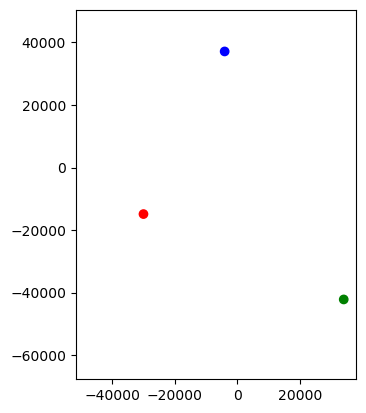

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anim

# Particle has a mas, position, velocity, and acceleration, the last of which is affected by the forces acting upon it
class particle(object):
    def __init__(self, xpos, ypos, xvel, yvel, mass):
        self.xpos = xpos
        self.ypos = ypos
        self.xvel = xvel
        self.yvel = yvel
        self.xacc = 0
        self.yacc = 0
        self.xfor = 0
        self.yfor = 0
        self.mass = mass

    def updatenetforce(self, others=[], gravconst=6.67e-11):
        """
        Updates the x and y forces acting on the particle

        :param others: list of other particles
        :param gravconst: the gravitational constant if you want to change it
        """
        others = np.array(others).astype(particle)
        self.xfor = 0
        self.yfor = 0
        for part in others:
            distancevec = [self.xpos - part.xpos, self.ypos - part.ypos]
            distancemag = np.sqrt(distancevec[0]**2+distancevec[1]**2)
            self.xfor += -distancevec[0]*gravconst*self.mass*part.mass/distancemag**3
            self.yfor += -distancevec[1]*gravconst*self.mass*part.mass/distancemag**3

    def step(self, dt=1):
        """
        Steps the particle forward in time

        :param dt: the interval that the change in position is estimated
        """
        self.xacc = self.xfor/self.mass
        self.yacc = self.yfor/self.mass
        self.xvel += 0.5*self.xacc*dt**2
        self.yvel += 0.5*self.yacc*dt**2
        self.xpos += 0.5*self.xvel*dt**2
        self.ypos += 0.5*self.yvel*dt**2


one = particle(1e4, 0, 0, 175e1, 5e20)
two = particle(1e4*np.cos(2*np.pi/3), 1e4*np.sin(2*np.pi/3), -18e2*np.sin(2*np.pi/3), 18e2*np.cos(2*np.pi/3), 5e20)
three = particle(1e4*np.cos(4*np.pi/3), 1e4*np.sin(4*np.pi/3), -18e2*np.sin(4*np.pi/3), 18e2*np.cos(4*np.pi/3), 5e20)

## Simulation parameters
start = 0
stop = 800
totaltime = stop - start
delt = 1
gconst = 6.67e-11

# Simulaiton routine
simulation1, simulation2, simulation3 = [], [], []
for i in range(int(totaltime//delt)):
    simulation1.append([one.xpos, one.ypos])
    simulation2.append([two.xpos, two.ypos])
    simulation3.append([three.xpos, three.ypos])
    one.updatenetforce(others=[two, three])
    two.updatenetforce(others=[three, one])
    three.updatenetforce(others=[one, two])
    one.step(dt=delt)
    two.step(dt=delt)
    three.step(dt=delt)

simulation1 = np.array(simulation1).astype(float)
simulation2 = np.array(simulation2).astype(float)
simulation3 = np.array(simulation3).astype(float)

fig, ax = plt.subplots()

artists = []
colors = ['red', 'green', 'blue']
for i in range(int(totaltime//delt)):
    container = ax.scatter([simulation1[i][0], simulation2[i][0], simulation3[i][0]], [simulation1[i][1], simulation2[i][1], simulation3[i][1]], color=colors)
    artists.append(container.findobj())

ax.set_aspect('equal')
ani = anim.ArtistAnimation(fig=fig, artists=artists)
writer = anim.writers['ffmpeg'](fps=30)
ani.save("../Files/gravitysimulation-redslower.mp4", writer=writer, dpi=200)
plt.show()

## TODO
Using matplotlib is slow for this
Need to use a better method for saving a video -> I chose opencv, I'll see where that goes.

In [ ]:
import numpy as np
import cv2 as cv

## Initial conditions
position = np.array([300, 0])
velocity = np.array([-10, 0])

## Simulating parameters
starttime = 0
dt = 1
totaltime = 10

frames = np.zeros((10,512,512,3), np.uint8)
simulation = np.array([position + velocity*d for d in range(starttime, totaltime, dt)])

fourcc = cv.VideoWriter.fourcc(*'3IVD')
video = cv.VideoWriter("../Files/linearmotion.mp4", fourcc, 30, (512,512), True)

for i, frame in enumerate(frames):
    for j, line in enumerate(frame):
        for k, pixel in enumerate(line):
            if j == simulation[i][]
    video.write(frame)

video.release()

ValueError: could not broadcast input array from shape (2,) into shape (1,512,3)